In [1]:
from graphviz import Digraph
import numpy as np

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# Lab 3: Backpropagation

## Computational Graph Visualization

In [58]:
import math

class Value:
    """Holding data class"""
    def __init__(self, data, _children=(), _op='', label=''):
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.data = data
        self.grad = 0.0 # gradient
        self._backward = lambda: None
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other

    def __gt__(self, other):  # >
            other_data = other.data if isinstance(other, Value) else other
            return self.data > other_data

    def __lt__(self, other):  # <
            other_data = other.data if isinstance(other, Value) else other
            return self.data < other_data

    def __ge__(self, other):  # >=
        other_data = other.data if isinstance(other, Value) else other
        return self.data >= other_data

    def __le__(self, other):  # <=
        other_data = other.data if isinstance(other, Value) else other
        return self.data <= other_data

    def __sub__(self, other):
        return self + (-1 * other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other -1)) * out.grad
            
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        tan = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(tan, (self, ), 'tanh')
        
        def _backward():
            self.grad +=  (1 - out.data**2) * out.grad
            
        out._backward = _backward
        return out
        
    
    def backward(self):
        topo = []
        visited = set()  
        
        def build_topology(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topology(child)
                topo.append(node)
    
        build_topology(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value(data={self.data})"

## Value Class (Autograd Engine)

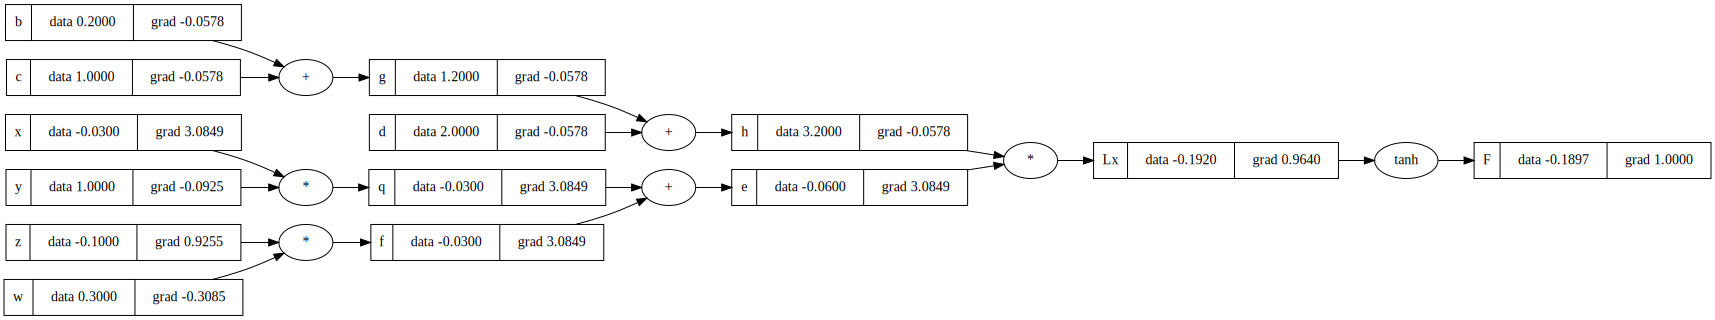

In [59]:
def test(): 
    def f(x, y, z, w, b, c, d):
        x = Value(x, label='x')
        y = Value(y, label='y')
        z = Value(z, label='z')
        w = Value(w, label='w')
        b = Value(b, label='b')
        c = Value(c, label='c')
        d = Value(d, label='d')
        q = x * y; q.label = 'q'
        f = z * w; f.label = 'f'
        g = b + c; g.label = 'g'
        h = g + d; h.label = 'h'
        e = f + q; e.label = 'e'
        Lx = e * h; Lx.label = 'Lx'
        F = Lx.tanh(); F.label = 'F'
        return F

    L = f(-0.03, 1, -0.1, 0.3, 0.2, 1, 2)
    L.backward()
    return L

L = test()
draw_dot(L)

## Testing Backpropagation

In [79]:
import random

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    
    def parameters(self):
        return []
    
def relu(x):
    return x if x > 0 else 0

class Neuron:
    def __init__(self, n_inputs, nonlinearity=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(0)
        self.nonlinearity = nonlinearity
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh() if self.nonlinearity else act

    def parameters(self):
        return self.w + [self.b]
        
    def __repr__(self):
        return f"Nonlinearity={self.nonlinearity} Neuron(weights={self.w}, bias={self.b})"

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in, nonlinearity=True) for _ in range(n_out)]
    
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __repr__(self):
        return f"Layer(neurons={self.neurons})"

class MLP(Module):
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"MLP(layers={self.layers})"


## Building a Neural Network

In [80]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=20, noise=0.1, random_state=42)

nn = MLP(2, [16, 16, 1])

for k in range(200):
    y_preds = []
    for x in X:
        x_vals = list(x)
        y_pred = nn(x_vals)[0]
        y_pred = 0.5*(y_pred + 1)
        y_preds.append(y_pred)
    
    loss_function = 0.0
    for i, y_pred in enumerate(y_preds):
        loss_function+= (y_pred - Value(y[i]))**2
    loss_function /= len(y_preds)
    
    nn.zero_grad()
    loss_function.backward()
    
    learning_rate = 0.001
    for p in nn.parameters():
        p.data += -learning_rate * p.grad
    
    if k % 5 == 0:
        print(f"Step {k}, loss={loss_function.data}")

Step 0, loss=0.5774550674718019
Step 5, loss=0.5765900042823369
Step 10, loss=0.575723016036444
Step 15, loss=0.5748540263297415
Step 20, loss=0.5739829511038351
Step 25, loss=0.5731096985657271
Step 30, loss=0.5722341691034655
Step 35, loss=0.5713562551969762
Step 40, loss=0.5704758413230113
Step 45, loss=0.56959280385318
Step 50, loss=0.5687070109440197
Step 55, loss=0.567818322418106
Step 60, loss=0.5669265896351913
Step 65, loss=0.5660316553523889
Step 70, loss=0.5651333535724264
Step 75, loss=0.5642315093790023
Step 80, loss=0.5633259387582877
Step 85, loss=0.5624164484056191
Step 90, loss=0.5615028355164344
Step 95, loss=0.560584887560497
Step 100, loss=0.5596623820384521
Step 105, loss=0.5587350862197518
Step 110, loss=0.5578027568609706
Step 115, loss=0.5568651399035225
Step 120, loss=0.5559219701497643
Step 125, loss=0.5549729709164565
Step 130, loss=0.5540178536645141
Step 135, loss=0.5530563176039652
Step 140, loss=0.5520880492729869
Step 145, loss=0.5511127220898605
Step 15

## Training on Make Moons

In [78]:
X

array([[ 1.14623781,  0.1538715 ],
       [ 1.52213386, -0.08244349],
       [ 1.14854378, -0.50119446],
       [ 0.79205965,  0.49071824],
       [-0.94213814,  0.37757528],
       [-0.13194707,  1.06805394],
       [ 0.03096746,  0.154996  ],
       [ 0.50951258,  0.93249084],
       [ 1.92567077,  0.15466052],
       [ 1.42509235, -0.4438636 ],
       [ 0.59488429, -0.20794035],
       [ 0.72922735,  0.68034407],
       [-1.11931582, -0.04090519],
       [ 1.95532585,  0.65242416],
       [ 0.20594816,  0.84546606],
       [ 0.01612213, -0.24717725],
       [-0.74877507,  0.67520749],
       [ 0.07458595,  0.31634168],
       [ 0.88279825, -0.48225769],
       [-0.45268068,  0.93194446]])

### Dataset